In [22]:
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, AUC
from sklearn.metrics import confusion_matrix, recall_score, precision_score,f1_score
import seaborn as sns
from matplotlib import pyplot as plt
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import TimeSeriesSplit

In [25]:
from importlib import reload
import EuroTruck.ProcessEuroTruckData.process_ets_data
reload(EuroTruck.ProcessEuroTruckData.process_ets_data)
from EuroTruck.ProcessEuroTruckData.process_ets_data import data_group
from EuroTruck.ProcessEuroTruckData.process_ets_data import data_rq
from EuroTruck.ProcessEuroTruckData.process_ets_data import data_michele

In [ ]:
def seperate_ground_truth(data, size, step):
    awake_window = []
    light_drowsy_window = []
    drowsy_window = []
    general_window = []
    time = next(iter(data.table))
    while time + datetime.timedelta(seconds=size) <= next(reversed(data.table)):
        awake_count = 0
        light_drowsy_count = 0
        drowsy_count = 0
        for i in range(size):
            check_time = time + datetime.timedelta(seconds=i)
            if check_time not in data.table:
                break
            if data.table[check_time]["groud_truth"] == [1]:
                awake_count += 1
            if data.table[check_time]["groud_truth"] == [2] or data.table[check_time]["groud_truth"] == [3]:
                light_drowsy_count += 1
            if data.table[check_time]["groud_truth"] == [4]:
                drowsy_count += 1

        if awake_count == size:
            general_window.append([time + datetime.timedelta(seconds=i) for i in range(size)])
            awake_window.append([time + datetime.timedelta(seconds=i) for i in range(size)])
        if light_drowsy_count == size:
            general_window.append([time + datetime.timedelta(seconds=i) for i in range(size)])
            light_drowsy_window.append([time + datetime.timedelta(seconds=i) for i in range(size)])
        if drowsy_count == size:
            general_window.append([time + datetime.timedelta(seconds=i) for i in range(size)])
            drowsy_window.append([time + datetime.timedelta(seconds=i) for i in range(size)])

        step_seconds = datetime.timedelta(seconds=step)
        time += step_seconds
    
    # 因为这里awake——window只会用来决定某个窗口的ground truth，所以转换成set可以方便查找    
    awake_window=set([tuple(window) for window in awake_window])
    light_drowsy_window=set([tuple(window) for window in light_drowsy_window])
    drowsy_window=set([tuple(window) for window in drowsy_window])
    
    # drowsy window is a list of list of datetime objects which is the key
    return awake_window, light_drowsy_window, drowsy_window, general_window


def define_feature_matrix(data, awake_window, light_drowsy_window, drowsy_window, general_window,sampling_rate,size):
    if general_window == []:
        return np.empty((0, sampling_rate*size, 4))
    feature_matrix = []
    label = []
    for window in general_window:
        feature_matrix_per_window = []

        SWA_colunm = []
        for time in window:
            SWA_colunm.extend(data.table[time]["SWA_data"])
        feature_matrix_per_window.append(SWA_colunm)

        SWV_column = []
        for time in window:
            SWV_column.extend(data.table[time]["SWV_data"])
        feature_matrix_per_window.append(SWV_column)

        LD_column = []
        for time in window:
            LD_column.extend(data.table[time]["lateral_displacement_data"])
        feature_matrix_per_window.append(LD_column)

        LA_column = []
        for time in window:
            LA_column.extend(data.table[time]["lateral_acceleration_data"])
        feature_matrix_per_window.append(LA_column)

        feature_matrix_per_window = np.transpose(np.array(feature_matrix_per_window))
        feature_matrix.append(feature_matrix_per_window)
        if tuple(window) in awake_window:
            label.append(0)
        if tuple(window) in light_drowsy_window:
            label.append(1)
        if tuple(window) in drowsy_window:
            label.append(2)
        
    feature_matrix = np.array(feature_matrix)
    label = np.array(label)
    return feature_matrix, label

size= 10
step = 1
sample_rate = data_group.get_min_sampling_rate()

In [48]:

X_train,y_train = define_feature_matrix(data_rq, *seperate_ground_truth(data_rq, size, step), sample_rate, size)
X_rest,y_rest = define_feature_matrix(data_michele, *seperate_ground_truth(data_michele, size, step), sample_rate, size)
X_val=X_rest[:int(X_rest.shape[0]/2)]
y_val=y_rest[:int(y_rest.shape[0]/2)]
X_test=X_rest[int(X_rest.shape[0]/2):]
y_test=y_rest[int(y_rest.shape[0]/2):]



In [28]:
# weight_for_0 = (1 / len(awake_window)) * (len(label) / 2.0)
# weight_for_1 = (1 / len(light_drowsy_window)) * (len(label) / 2.0)
# # weight_for_2 = (1 / len(drowsy_window)) * (len(label) / 3.0)
# weight_for_2 = 0
# class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

space = {
    'conv_filters_1': hp.choice('conv_filters_1', [32, 64, 128]),
    'conv_filters_2': hp.choice('conv_filters_2', [32, 64, 128]),
    'conv_filters_3': hp.choice('conv_filters_3', [32, 64, 128]),
    'conv_filters_4': hp.choice('conv_filters_4', [32, 64, 128]),
    'mini_batch_size': hp.choice('mini_batch_size', [32, 64, 128]),
    'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01]),
    'pooling_size_hyperopt': hp.choice('pooling_size_hyperopt', [2,3]),
    'neurons_lstm': hp.choice('neurons_lstm', [32, 64, 128]),
    'neurons_gru': hp.choice('neurons_gru', [32, 64, 128])
}

space_params = {
    'conv_filters_1': [32, 64, 128],
    'conv_filters_2': [32, 64, 128],
    'conv_filters_3': [32, 64, 128],
    'conv_filters_4': [32, 64, 128],
    'learning_rate': [0.001, 0.005, 0.01],
    'mini_batch_size': [32, 64, 128],
    'pooling_size_hyperopt': [2,3],
    'neurons_lstm': [32, 64, 128],
    'neurons_gru': [32, 64, 128]
}


def make_model(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=space['learning_rate'][best_params['learning_rate']]), loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=['categorical_accuracy'])
    return model

def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    labels=[0,1,2]
    y_pred=[]
    for row in model.predict(X_test):
        y_pred.append(np.argmax(row))
    y_pred=np.array(y_pred) 
    cm = confusion_matrix(y_test, y_pred,labels=labels)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()

In [ ]:

def objective(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25,gamma=3), metrics=['categorical_accuracy'])
    model.fit(X_train, y_train_one_hot, epochs=150, batch_size=params['mini_batch_size'], verbose=0)
    f1=f1_score(y_val, model.predict(X_val,verbose=0).argmax(axis=1), average='weighted',zero_division=0)
    return -f1

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=3)
trials = Trials()
best_params_weighted = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

In [52]:

print("Best hyperparameters:", best_params_weighted)

Best hyperparameters: {'conv_filters_1': 1, 'conv_filters_2': 1, 'conv_filters_3': 1, 'conv_filters_4': 2, 'learning_rate': 0, 'mini_batch_size': 2, 'neurons_gru': 1, 'neurons_lstm': 2, 'pooling_size_hyperopt': 0}


In [ ]:

best_weighted_model = make_model(space_params, best_params_weighted)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


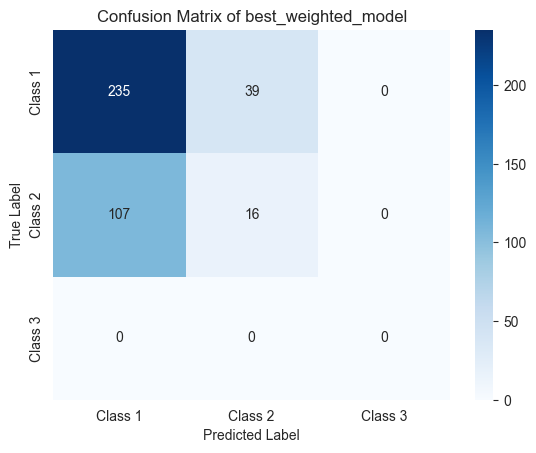

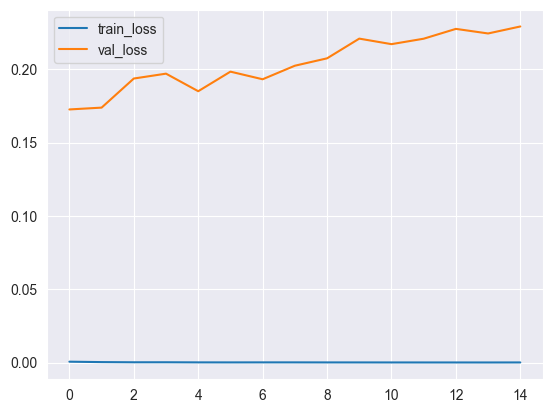

In [44]:

history=best_weighted_model.fit(X_train, y_train_one_hot, epochs=15,batch_size=space_params['mini_batch_size'][best_params_weighted['mini_batch_size']], validation_data=(X_val, y_val_one_hot), verbose=0)
confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_test, y_test)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()  

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


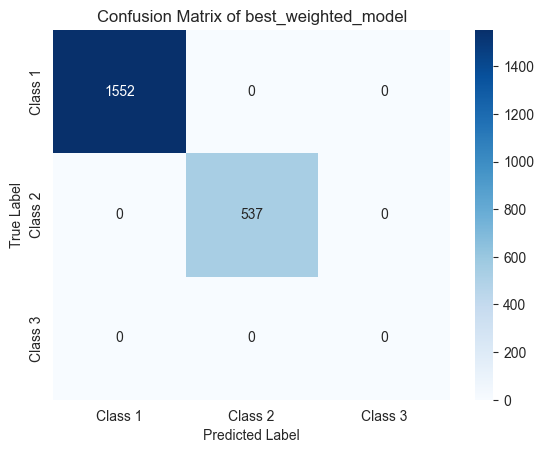

In [46]:
confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_train, y_train)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


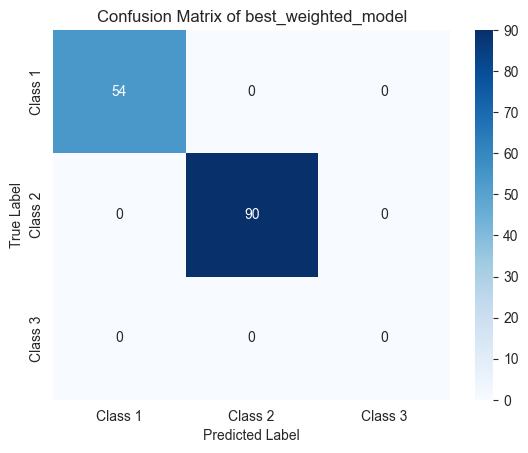

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


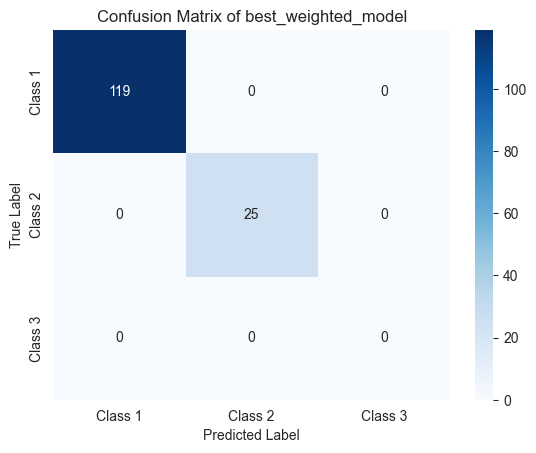

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


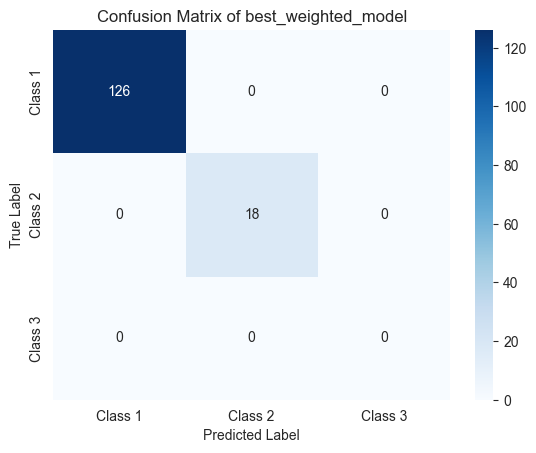

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


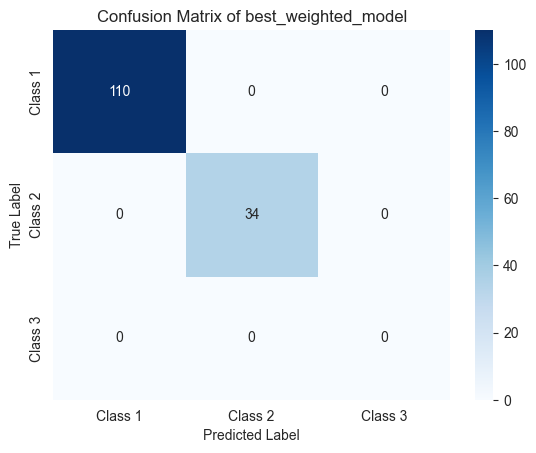

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


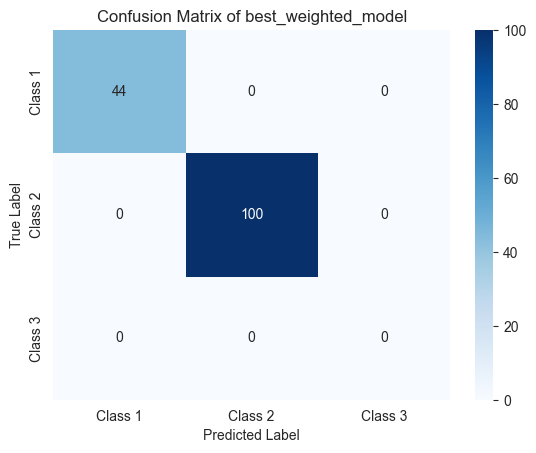

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


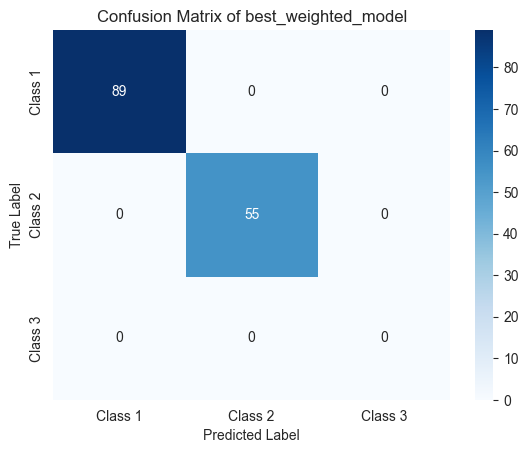

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


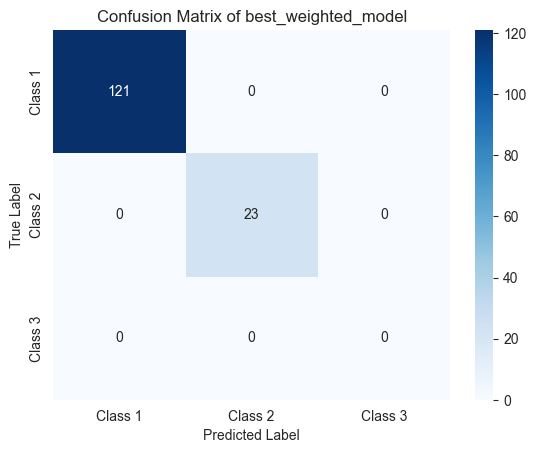

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


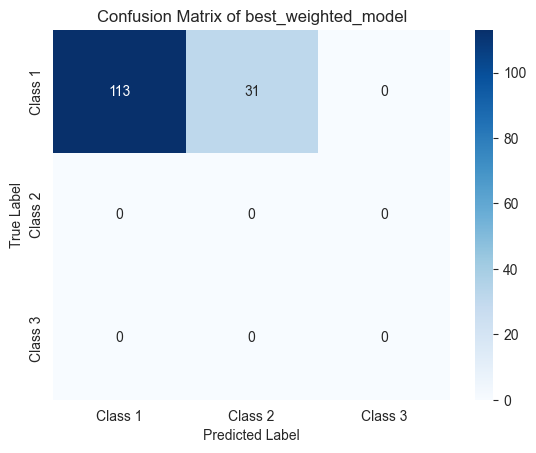

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


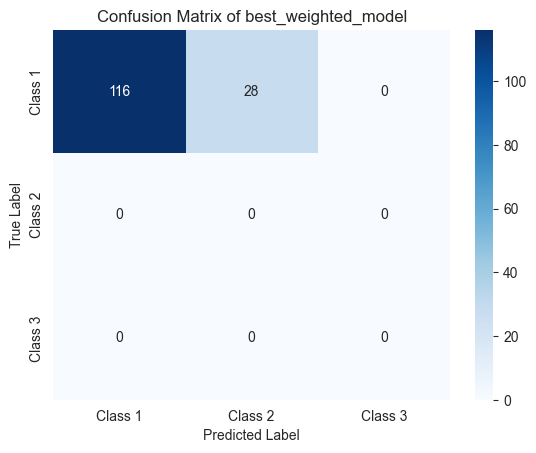

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


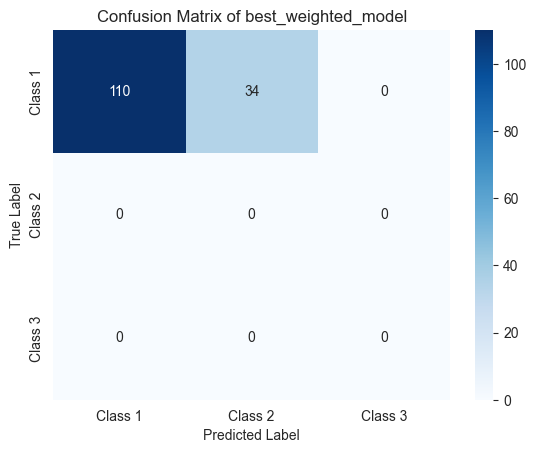

In [51]:
tscv = TimeSeriesSplit(n_splits=10)
for train_index, test_index in tscv.split(X_rest):
    X_train_train, X_train_test = X_rest[train_index], X_rest[test_index]
    y_train_train, y_train_test = y_rest[train_index], y_rest[test_index]
    y_train_train_one_hot = tf.keras.utils.to_categorical(y_train_train, num_classes=3)
    y_train_test_one_hot = tf.keras.utils.to_categorical(y_train_test, num_classes=3)
    best_weighted_model.fit(X_train_train, y_train_train_one_hot, epochs=15,batch_size=space_params['mini_batch_size'][best_params_weighted['mini_batch_size']], validation_data=(X_train_test, y_train_test_one_hot), verbose=0)
    confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_train_test, y_train_test)